1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━

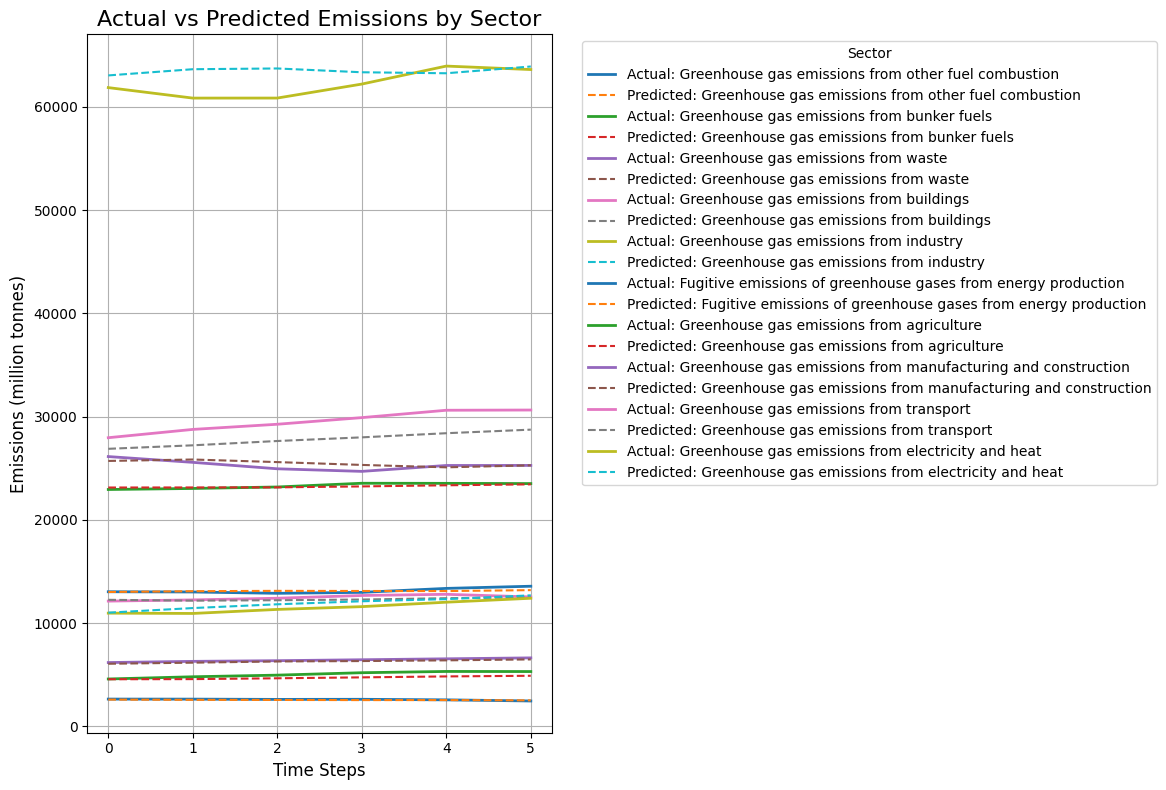

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('ghg-emissions-by-sector-stacked.csv')

sector_columns = [
    'Greenhouse gas emissions from other fuel combustion',
    'Greenhouse gas emissions from bunker fuels',
    'Greenhouse gas emissions from waste',
    'Greenhouse gas emissions from buildings',
    'Greenhouse gas emissions from industry',
    'Fugitive emissions of greenhouse gases from energy production',
    'Greenhouse gas emissions from agriculture',
    'Greenhouse gas emissions from manufacturing and construction',
    'Greenhouse gas emissions from transport',
    'Greenhouse gas emissions from electricity and heat'
]

# Group the data by 'Year' and sum emissions for each sector
global_emissions_by_sector = data.groupby('Year')[sector_columns].sum() / 1e6

# Function to create a time-series dataset for LSTM input
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Function to predict future emissions based on the trained model
def predict_future_emissions(model, last_sequence, num_years, scaler, time_step):
    predictions = []
    current_sequence = last_sequence.copy()

    # Generate predictions for the given number of future years
    for _ in range(num_years):
        next_emission = model.predict(current_sequence.reshape(1, time_step, 1))
        predictions.append(next_emission[0, 0])
        current_sequence = np.append(current_sequence[1:], next_emission, axis=0)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Set number of future years to predict
num_future_years = 10
time_step = 3  # Define the number of previous time steps to use as input features

# Initialize dictionaries to store predictions and error metrics
future_predictions = {}
actual_vs_predicted = {}
mse_values, rmse_values, mae_values = {}, {}, {}
train_mse_values = {}

# Training parameters
epochs = 200
learning_rate = 0.001
dropout_rate = 0.2

# Loop through each sector to train an LSTM model and make predictions
for sector in sector_columns:

    # Get the data for the specific sector and scale it using MinMaxScaler
    sector_data = global_emissions_by_sector[[sector]]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sector_data = scaler.fit_transform(sector_data)

    # Create the dataset with the given time step
    X, y = create_dataset(scaled_sector_data, time_step)
    X = X.reshape((X.shape[0], time_step, 1))

    # Split the data into training (80%) and testing (20%) sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define and compile the LSTM model
    model = Sequential()
    model.add(Input(shape=(time_step, 1)))  # Explicit input layer
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0)

    # Predict the emissions for both the test and training datasets
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Inverse transform the predicted values back to the original scale
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate error metrics for the test data
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    train_mse = mean_squared_error(y_train, y_pred_train)

    mse_values[sector] = mse
    rmse_values[sector] = rmse
    mae_values[sector] = mae
    train_mse_values[sector] = train_mse

    # Predict future emissions based on the most recent data point
    last_sequence = scaled_sector_data[-time_step:]
    future_emissions = predict_future_emissions(model, last_sequence, num_future_years, scaler, time_step)
    future_predictions[sector] = future_emissions

    actual_vs_predicted[sector] = (y_test_actual, y_pred_actual)
    

for sector in sector_columns:
    print(f"{sector}")
    print(f"Testing Mean Squared Error (MSE):  {mse_values[sector]:.2f}")
    print(f"Training Mean Squared Error (MAE):  {train_mse_values[sector]:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_values[sector]:.2f}")
    print(f"Mean Absolute Error (MAE):  {mae_values[sector]:.2f}")
    print("-" * 40)

years = np.arange(global_emissions_by_sector.index[-1] + 1, global_emissions_by_sector.index[-1] + num_future_years + 1)

# Plot actual vs predicted for each sector
fig, ax2 = plt.subplots(figsize=(12, 8))

for sector in sector_columns:
    y_test_actual, y_pred_actual = actual_vs_predicted[sector]
    ax2.plot(np.arange(len(y_test_actual)), y_test_actual, label=f"Actual: {sector}", linestyle='-', linewidth=2)
    ax2.plot(np.arange(len(y_pred_actual)), y_pred_actual, label=f"Predicted: {sector}", linestyle='--')

ax2.set_title('Actual vs Predicted Emissions by Sector', fontsize=16)
ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('Emissions (million tonnes)', fontsize=12)
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Sector")
ax2.grid(True)

plt.tight_layout()
plt.show()


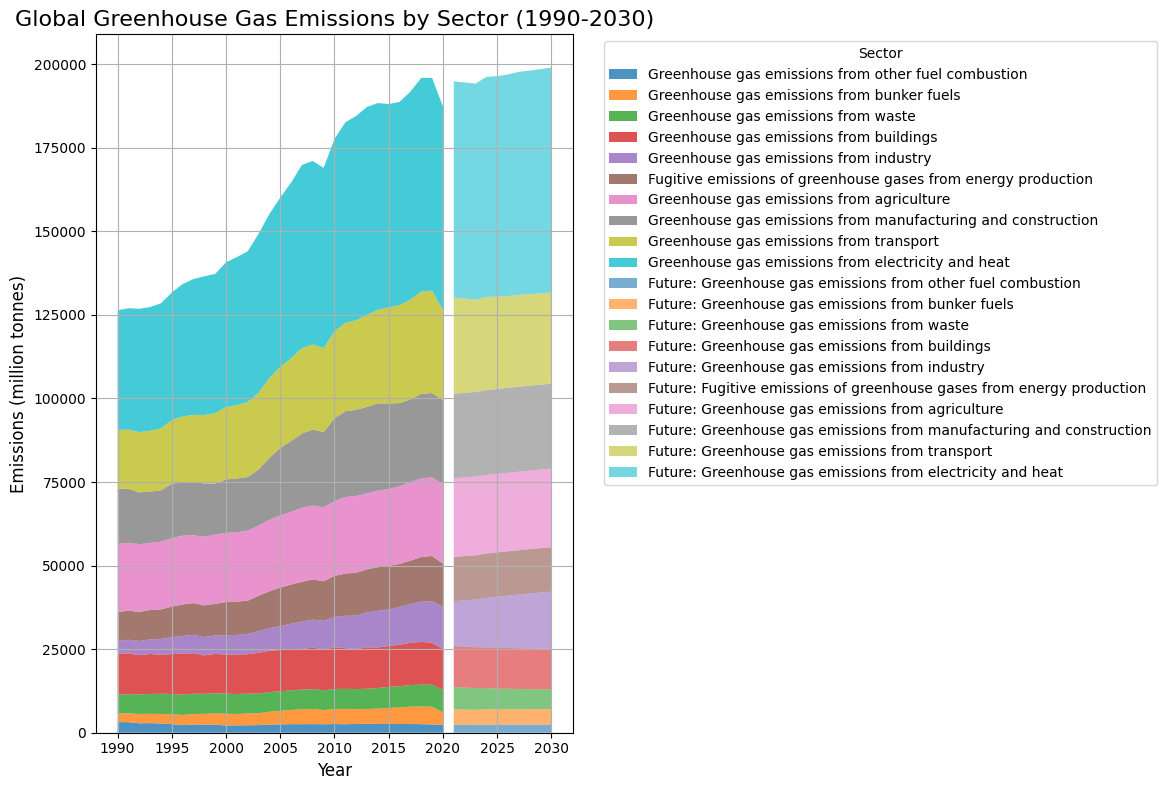

In [3]:
# Prepare future predictions in the correct format for stack plotting
future_predictions_stacked = np.array([future_predictions[sector].flatten() for sector in sector_columns])

# Plot historical emissions as a stacked area chart
fig, ax1 = plt.subplots(figsize=(12, 8))

# Stacked area plot for historical emissions
ax1.stackplot(global_emissions_by_sector.index, global_emissions_by_sector.T, labels=sector_columns, alpha=0.8)
ax1.set_title('Global Greenhouse Gas Emissions by Sector (1990-2030)', fontsize=16)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Emissions (million tonnes)', fontsize=12)

# Add future predictions as a stacked area plot
ax1.stackplot(years, future_predictions_stacked, labels=[f"Future: {sector}" for sector in sector_columns], alpha=0.6, linestyle='--')

# Add legend and grid
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Sector")
ax1.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()